In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Using cpu device


# Prepare data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!python bboxes_extractor.py --save-dir data/reference_images_part1_bboxes --dir-from /content/drive/MyDrive/data/reference_images_part1 --data-json /content/drive/MyDrive/data/reference_images_part1.json

In [4]:
!python bboxes_extractor.py --save-dir data/images_part1_valid_bboxes --dir-from /content/drive/MyDrive/data/images_part1_valid --data-json /content/drive/MyDrive/data/images_part1_valid.json

# Dataset

In [3]:
from typing import Optional, Callable, Tuple, Any
import numpy as np
from PIL import Image
import os


class MagicDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        img_dir: str,
        labels_file: Optional[str] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ) -> None:

        self.img_dir = img_dir
        self.labels_file = labels_file
        self.data = pd.read_csv(labels_file)
        self.img_names = self.data.loc[:, "filename"]
        self.img_labels = self.data.loc[:, "category_id"]
        self.class_names = self.img_labels.unique()

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_names)

    def __getitem__(self, index: int):
        img_path = os.path.join(self.img_dir, self.img_names[index])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels[index]

        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)

        return image, label
    

In [5]:
IMG_DIR = './data/reference_images_part1_bboxes/images'
LABELS_FILE = './data/reference_images_part1_bboxes/bboxes_data.csv'
IMG_DIR_VAL = './data/images_part1_valid_bboxes/images'
LABELS_FILE_VAL = './data/images_part1_valid_bboxes/bboxes_data.csv'

In [6]:
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [7]:
train_data = MagicDataset(img_dir=IMG_DIR, labels_file=LABELS_FILE, transform=transformations)
val_data = MagicDataset(img_dir=IMG_DIR_VAL, labels_file=LABELS_FILE_VAL, transform=transformations)

In [8]:
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
# val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, sampler=val_sampler)

In [9]:
trainx, trainy = next(iter(train_loader))
trainx.shape, trainy.shape

(torch.Size([144, 3, 224, 224]), torch.Size([144]))

In [10]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support+n_querry, for n_way classes
    Args:
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
        datax (np.array): dataset of images
        datay (np.array): dataset of labels
    Returns:
        (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = torch.zeros((0, n_support+n_query, 3, trainx.shape[-2], trainx.shape[-1]))
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support+n_query)]
        sample = torch.cat([sample, torch.as_tensor(sample_cls).unsqueeze(0)])
    return({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
        })

In [11]:
sample_example = extract_sample(8, 2, 1, trainx, trainy)

In [12]:
sample_example['images'].shape

torch.Size([8, 3, 3, 224, 224])

In [51]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


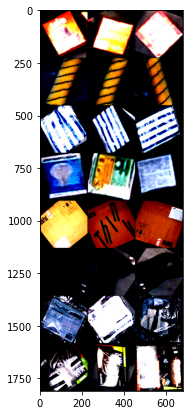

In [53]:
display_sample(sample_example['images'])

# Model 

In [53]:
model = models.resnet50(pretrained=True)

for i, child in enumerate(model.children()):
    if i < 7:
        for param in child.parameters():
            param.requires_grad = False

model = torch.nn.Sequential(*(list(model.children())[:-1]), torch.nn.Flatten())
model = model.to(device)

In [54]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].to(device)
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    # target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = target_inds.to(device)
   
    # encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    z = self.encoder(x)
    z_dim = z.size(-1) 
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    # compute distances
    dists = euclidean_dist(z_query, z_proto)
    
    # compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
   
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [55]:
def euclidean_dist(x, y):
    """
    Computes euclidean distance btw x and y
    Args:
        x (torch.Tensor): shape (n, d). n usually n_way*n_query
        y (torch.Tensor): shape (m, d). m usually n_way
    Returns:
        torch.Tensor: shape(n, m). For each query, the distances to each centroid
    """
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [56]:
from tqdm import tqdm_notebook
from tqdm import tnrange

def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  # divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 # epochs done so far
  stop = False # status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [ ]:
%%time

optimizer = optim.Adam(model.parameters(), lr = 1e-4)
n_way = 8
n_support = 2
n_query = 1

model = ProtoNet(model)

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 10

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Epoch 1 train:   0%|          | 0/10 [00:00<?, ?it/s]